=== Available Columns ===
0: Unnamed: 0
1: Unnamed: 1
2: Unnamed: 2
3: Trustworthiness
4: Unnamed: 4
5: Unnamed: 5
6: expertise
7: Unnamed: 7
8: Unnamed: 8
9: physical attractiveness
10: Unnamed: 10
11: Unnamed: 11
12: social attractiveness
13: Unnamed: 13
14: Unnamed: 14
15: Brand or product attributes
16: Unnamed: 16
17: Unnamed: 17
18: purchase intention
19: Unnamed: 19
20: Unnamed: 20
21: manipulation checks
22: Unnamed: 22
23: Unnamed: 23
24: Unnamed: 24

=== First 30 Column Names ===
Column 0: Unnamed: 0
Column 1: Unnamed: 1
Column 2: Unnamed: 2
Column 3: Trustworthiness
Column 4: Unnamed: 4
Column 5: Unnamed: 5
Column 6: expertise
Column 7: Unnamed: 7
Column 8: Unnamed: 8
Column 9: physical attractiveness
Column 10: Unnamed: 10
Column 11: Unnamed: 11
Column 12: social attractiveness
Column 13: Unnamed: 13
Column 14: Unnamed: 14
Column 15: Brand or product attributes
Column 16: Unnamed: 16
Column 17: Unnamed: 17
Column 18: purchase intention
Column 19: Unnamed: 19
Column 20: Unna

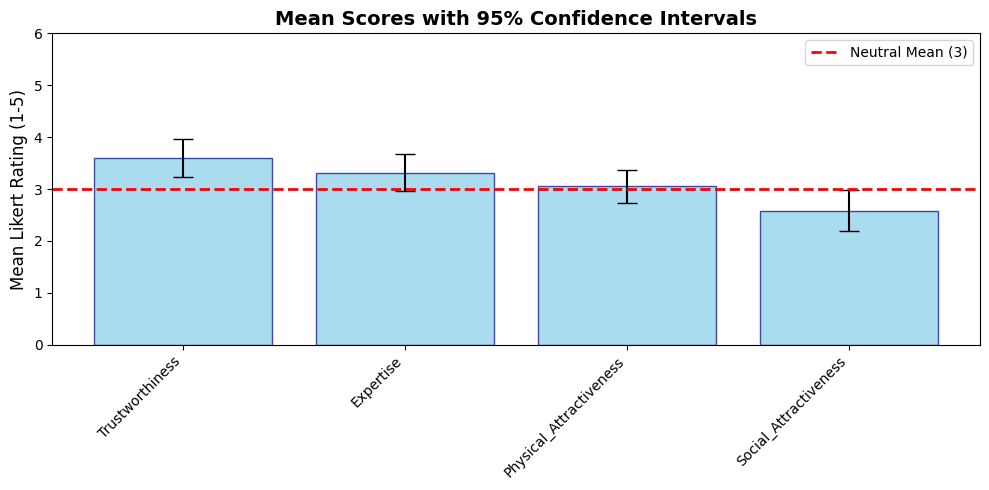

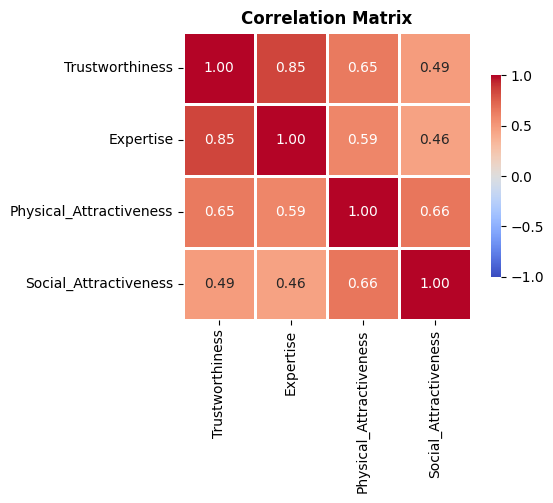


=== Regression Coefficients ===
                         Coefficient  Std Error   p-value
Trustworthiness             0.566821   0.195947  0.006927
Expertise                  -0.051249   0.189378  0.788480
Physical_Attractiveness    -0.023843   0.173766  0.891750
Social_Attractiveness       0.453782   0.119370  0.000632


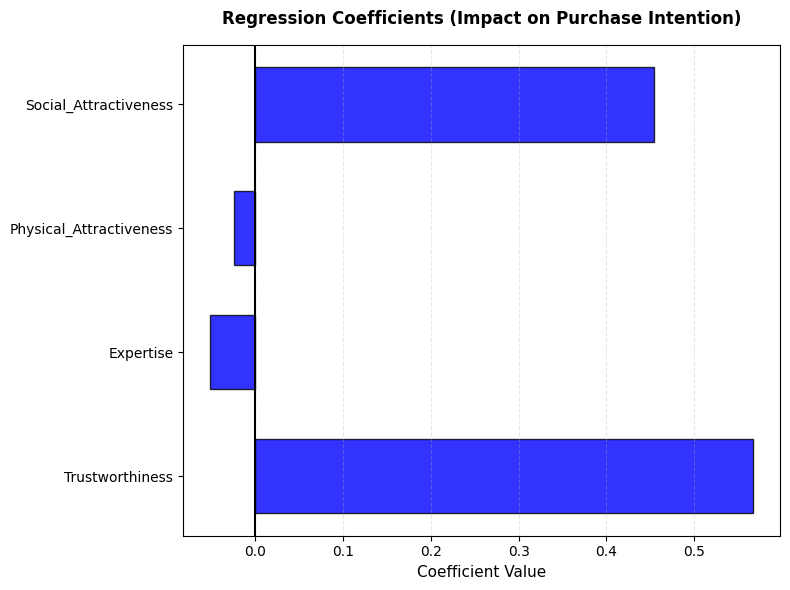

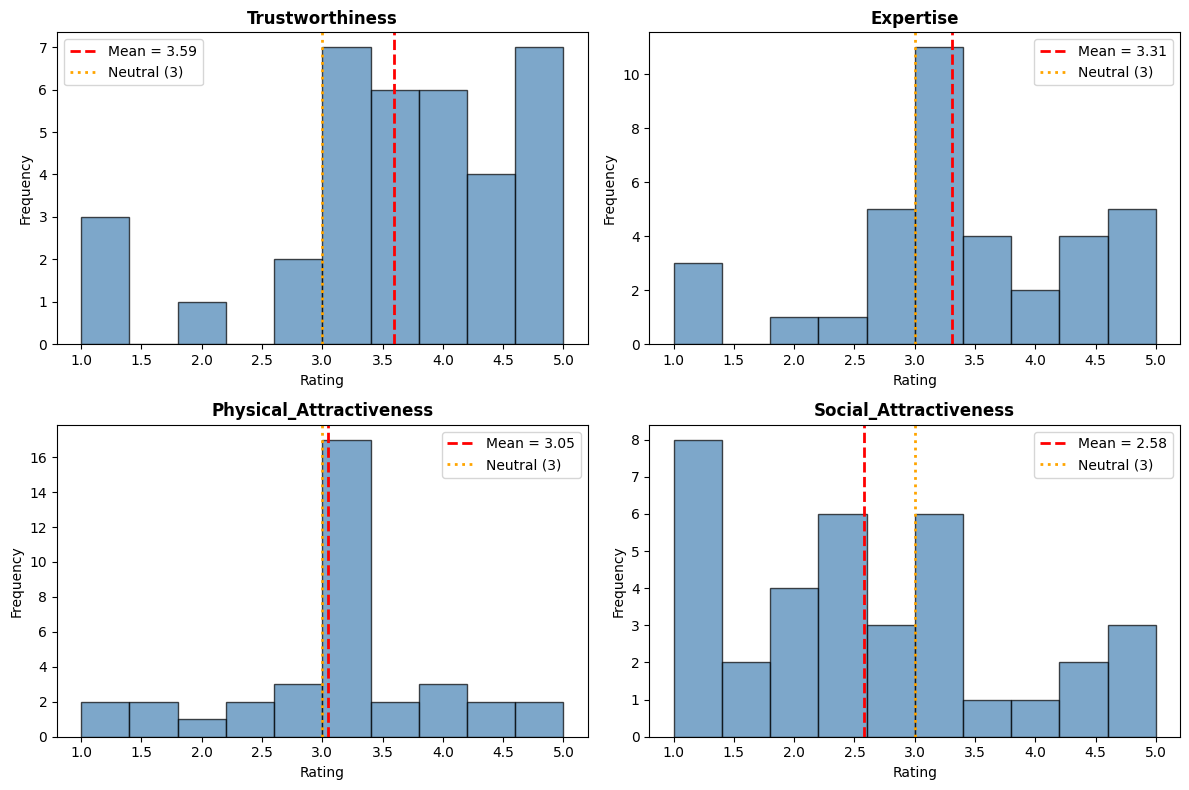

In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = "layperson.csv"
df = pd.read_csv(file_path, quotechar='"', skipinitialspace=True, engine='python')

print("=== Available Columns ===")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

likert_start = 3
likert_cols = df.columns[likert_start:]

for col in likert_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n=== First 30 Column Names ===")
for idx, col in enumerate(df.columns[:30]):
    print(f"Column {idx}: {col}")

trust_cols = df.columns[3:6] 
expert_cols = df.columns[6:9] 
phys_cols = df.columns[9:12]  
soc_cols = df.columns[12:15]
brand_cols = df.columns[15:18]
purchase_cols = df.columns[18:21]
manip_cols = df.columns[21:25]

print("\n=== Trustworthiness Columns ===")
print(list(trust_cols))
print("\n=== Expertise Columns ===")
print(list(expert_cols))
print("\n=== Physical Attractiveness Columns ===")
print(list(phys_cols))
print("\n=== Social Attractiveness Columns ===")
print(list(soc_cols))

df['Trustworthiness'] = df[trust_cols].mean(axis=1)
df['Expertise'] = df[expert_cols].mean(axis=1)
df['Physical_Attractiveness'] = df[phys_cols].mean(axis=1)
df['Social_Attractiveness'] = df[soc_cols].mean(axis=1)
df['Brand_Attributes'] = df[brand_cols].mean(axis=1)
df['Purchase_Intention'] = df[purchase_cols].mean(axis=1)

def construct_stats(series):
    series_clean = series.dropna()
    if len(series_clean) == 0:
        return np.nan, (np.nan, np.nan), np.nan
    
    mean = series_clean.mean()
    sem = stats.sem(series_clean)
    ci = stats.t.interval(0.95, len(series_clean)-1, loc=mean, scale=sem)
    t_stat, p_val = stats.ttest_1samp(series_clean, popmean=3)
    return mean, ci, p_val

credibility_constructs = ['Trustworthiness', 'Expertise', 'Physical_Attractiveness', 'Social_Attractiveness']
all_constructs = credibility_constructs + ['Brand_Attributes', 'Purchase_Intention']

for c in all_constructs:
    if c not in df.columns:
        continue
        
results = {c: construct_stats(df[c]) for c in credibility_constructs}

print("\n=== Construct Statistics (95% Confidence) ===")
for c, (mean, ci, p) in results.items():
    significance = "✅ Relevant (p < 0.05)" if p < 0.05 else "❌ Not Relevant (p ≥ 0.05)"
    print(f"{c:30s} | Mean = {mean:.2f} | 95% CI = ({ci[0]:.2f}, {ci[1]:.2f}) | p = {p:.4f} | {significance}")

print("\n=== Descriptive Statistics ===")
desc_stats = df[credibility_constructs].describe()
print(desc_stats)

corr = df[credibility_constructs].corr()
print("\n=== Correlation Matrix ===")
print(corr.round(2))

predictor_constructs = credibility_constructs
y = df['Purchase_Intention'].dropna()
X = df.loc[y.index, predictor_constructs]

valid_idx = X.notna().all(axis=1)
X = X[valid_idx]
y = y[valid_idx]

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print("\n=== Regression Results - Predicting Purchase Intention ===")
print(model.summary())

plt.figure(figsize=(10,5))
means = [results[c][0] for c in credibility_constructs]
cis = [results[c][1] for c in credibility_constructs]
ci_errors = [[abs(m - ci[0]), abs(ci[1] - m)] for m, ci in zip(means, cis)]
ci_errors_lower = [e[0] for e in ci_errors]
ci_errors_upper = [e[1] for e in ci_errors]

x_pos = np.arange(len(credibility_constructs))
plt.bar(x_pos, means, yerr=[ci_errors_lower, ci_errors_upper], capsize=7, 
        color='skyblue', edgecolor='navy', alpha=0.7)
plt.axhline(3, color='red', linestyle='--', linewidth=2, label='Neutral Mean (3)')
plt.xticks(x_pos, credibility_constructs, rotation=45, ha='right')
plt.title('Mean Scores with 95% Confidence Intervals', fontsize=14, fontweight='bold')
plt.ylabel('Mean Likert Rating (1-5)', fontsize=12)
plt.ylim(0, 6)
plt.legend()
plt.tight_layout()
plt.savefig('construct_means.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True, linewidths=1, cbar_kws={"shrink": 0.7})
plt.title('Correlation Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

coef_df = pd.DataFrame({
    'Coefficient': model.params[1:],
    'Std Error': model.bse[1:],
    'p-value': model.pvalues[1:]
})
print("\n=== Regression Coefficients ===")
print(coef_df)

short_labels = ['Trustworthiness', 'Expertise', 'Physical_Attractiveness', 'Social_Attractiveness']

fig, ax = plt.subplots(figsize=(8, 6))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

y_pos = np.arange(len(coef_df))
bars = ax.barh(y_pos, coef_df['Coefficient'], color='blue', edgecolor='black', alpha=0.8, height=0.6)

ax.axvline(0, color='black', linewidth=1.5, linestyle='-')

ax.set_yticks(y_pos)
ax.set_yticklabels(short_labels)
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title('Regression Coefficients (Impact on Purchase Intention)', fontsize=12, fontweight='bold', pad=15)

ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('regression_coefficients.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, construct in enumerate(credibility_constructs):
    data = df[construct].dropna()
    axes[i].hist(data, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {data.mean():.2f}')
    axes[i].axvline(3, color='orange', linestyle=':', linewidth=2, label='Neutral (3)')
    axes[i].set_title(construct, fontweight='bold')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
plt.show()